In [243]:
import pandas as pd
import geopandas as gpd
import numpy as np
from GPS.ACS.utils import *
import shapely.geometry
import json

In [228]:
from shapely.geometry import Point


# GPS point
p = Point(-86.15, 39.78)

# create circle
p_buff = p.buffer(.1)

# put point into df
point_frame = gpd.GeoDataFrame(pd.DataFrame({
    'input' : ['point'],
    'geometry' : p_buff
    
    
}))
      
# set point CRS
point_frame = point_frame.set_crs(epsg=4269)


In [229]:
point_frame

,input,geometry
0,point,"POLYGON ((-86.05000 39.78000, -86.05048 39.770..."


In [230]:
usa= pd.read_pickle('/Users/vinniepalazeti/Desktop/github/GPS/examples/data/storage/shape_US_data/us_states.pkl')

In [231]:
usa = usa.set_crs(epsg=4269)

In [232]:
states = gpd.sjoin(usa, point_frame,op='intersects')['GEOID'].values

In [233]:
state_data = []
for code_number in states:
    print(code_number)
    read_in = pd.read_pickle(f"/Users/vinniepalazeti/Desktop/github/GPS/examples/data/storage/shape_state_data/state_{code_number}.pkl")
    state_data.append(read_in)
    
state_data = pd.concat(state_data,axis=1)

18


<AxesSubplot:>

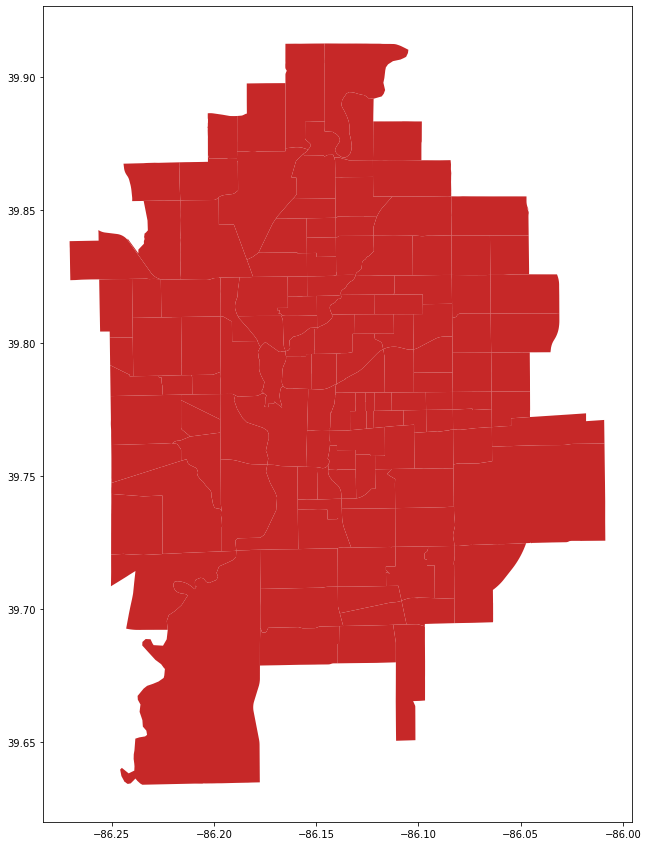

In [234]:
state = gpd.sjoin(state_data, point_frame,op='intersects')


state['color'] = '#C62828'

# joined.loc[len(joined)+1,['geometry','color'] ] = p_buff, '#283593'

state.plot(color=state['color'],figsize=(15,15))

# Get Tabular Data

In [235]:
state_tab_data = []
for code_number in states:
    print(code_number)
    read_in = pd.read_csv(f"/Users/vinniepalazeti/Desktop/github/GPS/examples/data/storage/tabular_state_data/data_state_{code_number}.csv",compression='gzip')
    state_tab_data.append(read_in)


    
state_tab_data = pd.concat(state_tab_data,axis=1) 

18


In [236]:
state['GEOID'] = state['GEOID'].astype(np.int64)
#temp = joined.set_index('GEOID').join(state_tab_data.set_index('GEOID'), how='left')
state_w_tab = state.merge(state_tab_data.round(3), on = 'GEOID', how='left')

In [237]:
# This should go into package specifically for this purpose
tab_list = [
    'Total Population',
    'Female 0-5',
    'Female 5-9',
    'Female 10-14',
    'Female 15-17',
    'Female 18-19',
    'Female 20',
    'Female 21',
    'Female 22-24',
    'Female 25-29',
    'Female 30-34',
    'Female 35-39',
    'Female 40-44',
    'Female 45-49',
    'Female 50-54',
    'Female 55-59',
    'Female 60-61',
    'Female 62-64',
    'Female 65-66',
    'Female 67-69',
    'Female 70-74',
    'Female 75-79',
    'Female 80-84',
    'Female 85+',
    'Female Pop Below 18',
    'Female Pop 18 to 24',
    'Female Pop 25 to 34',
    'Female Pop 35 to 44',
    'Female Pop 45 to 54',
    'Female Pop 55 to 64',
    'Female Pop 65+',
    'Male 0-5',
    'Male 5-9',
    'Male 10-14',
    'Male 15-17',
    'Male 18-19',
    'Male 20',
    'Male 21',
    'Male 22-24',
    'Male 25-29',
    'Male 30-34',
    'Male 35-39',
    'Male 40-44',
    'Male 45-49',
    'Male 50-54',
    'Male 55-59',
    'Male 60-61',
    'Male 62-64',
    'Male 65-66',
    'Male 67-69',
    'Male 70-74',
    'Male 75-79',
    'Male 80-84',
    'Male 85+',
    'Male Pop Below 18',
    'Male Pop 18 to 24',
    'Male Pop 25 to 34',
    'Male Pop 35 to 44',
    'Male Pop 45 to 54',
    'Male Pop 55 to 64',
    'Male Pop 65+',
    'Total 0-5',
    'Total 5-9',
    'Total 10-14',
    'Total 15-17',
    'Total 18-19',
    'Total 20',
    'Total 21',
    'Total 22-24',
    'Total 25-29',
    'Total 30-34',
    'Total 35-39',
    'Total 40-44',
    'Total 45-49',
    'Total 50-54',
    'Total 55-59',
    'Total 60-61',
    'Total 62-64',
    'Total 65-66',
    'Total 67-69',
    'Total 70-74',
    'Total 75-79',
    'Total 80-84',
    'Total 85+',
    'Total Pop Below 18',
    'Total Pop 18 to 24',
    'Total Pop 25 to 34',
    'Total Pop 35 to 44',
    'Total Pop 45 to 54',
    'Total Pop 55 to 64',
    'Total Pop 65+',
    'Income Total Population',
    'Income Below Poverty Line',
    'Median Income',
    'Education Attainment 18 to 64 Total',
    'Education Attainment Less than Highschool',
    'Education Attainment Highschool Graduate',
    'Education Attainment Bachelors Degree or Higher',
    'White Population',
    'Black Population',
    'Hispanic or Latino Population',
    'Arab Population',
    'American Indiana & Alaska Native Population',
    'Asian Population',
]

dissolved_data = state_w_tab[tab_list].sum(axis=0)


In [238]:
dissolved_data['geometry'] = state_w_tab[['geometry']].dissolve()

<AxesSubplot:>

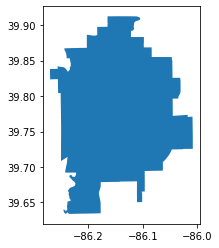

In [239]:
dissolved_data['geometry'].plot()

In [240]:
# dissolved_data['Name'] = 'Area Data'
# shapely.geometry.mapping(dissolved_data['geometry'])['features'][0]['geometry']['coordinates'][0]


# Create GeoJson File & dump

In [241]:
def df_to_geojson(df, properties):
    # create a new python dict to contain our geojson data, using geojson format
    geojson = {'type':'FeatureCollection', 'features':[]}

    # loop through each row in the dataframe and convert each row to geojson format
    
    if isinstance(df,pd.Series):
        feature = {'type':'Feature',
                       'properties':{},
                       'geometry':{'type':'Polygon',
                                   'coordinates':[]}}
        
        temp = shapely.geometry.mapping(df['geometry'])['features'][0]['geometry']['coordinates'][0]
        
        feature['geometry']['coordinates'] = [[list(temp[i]) for i in range(len(temp))]]
        
        geojson['features'].append(feature)

    else:
        for _, row in df.iterrows():
            # create a feature template to fill in
            feature = {'type':'Feature',
                       'properties':{},
                       'geometry':{'type':'Polygon',
                                   'coordinates':[]}}

            # fill in the coordinates
            temp = shapely.geometry.mapping(row['geometry'])['coordinates'][0]


            feature['geometry']['coordinates'] = [[list(temp[i]) for i in range(len(temp))]]

            # for each column, get the value and add it as a new feature property
            for prop in properties:
                feature['properties'][prop] = row[prop]

            # add this feature (aka, converted dataframe row) to the list of features inside our dict
            geojson['features'].append(feature)
    
    return geojson

In [242]:
# var states = [{
#     "type": "Feature",
#     "properties": {"party": "Republican"},
#     "geometry": {
#         "type": "Polygon",
#         "coordinates": [[
#             [-104.05, 48.99],
#             [-97.22,  48.98],
#             [-96.58,  45.94],
#             [-104.03, 45.94],
#             [-104.05, 48.99]
#         ]]
#     }
# }, {
#     "type": "Feature",
#     "properties": {"party": "Democrat"},
#     "geometry": {
#         "type": "Polygon",
#         "coordinates": [[
#             [-109.05, 41.00],
#             [-102.06, 40.99],
#             [-102.03, 36.99],
#             [-109.04, 36.99],
#             [-109.05, 41.00]
#         ]]
#     }
# }];

# # this format can be used, so I could mimc this

In [244]:
temp = df_to_geojson(dissolved_data, ['Name'])

with open('boarder.txt', 'w') as file:
     file.write(json.dumps(temp))

In [227]:


temp = df_to_geojson(state_w_tab, ['NAMELSAD','Total Population','White Population Percent',
    'Black Population Percent',
    'Hispanic or Latino Population Percent',
    'Arab Population Percent',
    'American Indiana & Alaska Native Population Percent',
    'Asian Population Percent'])

with open('geojson.txt', 'w') as file:
     file.write(json.dumps(temp))

In [226]:
temp


{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'NAMELSAD': 'Census Tract 3608',
    'Total Population': 2191,
    'White Population Percent': 0.644,
    'Black Population Percent': 0.297,
    'Hispanic or Latino Population Percent': 0.171,
    'Arab Population Percent': 0.0,
    'American Indiana & Alaska Native Population Percent': 0.005,
    'Asian Population Percent': 0.0},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-86.06440599999999, 39.796304],
      [-86.06199199999999, 39.796324999999996],
      [-86.061137, 39.796332],
      [-86.06088199999999, 39.796329],
      [-86.06030299999999, 39.796334],
      [-86.06010599999999, 39.796337],
      [-86.05986399999999, 39.796338999999996],
      [-86.056304, 39.796369],
      [-86.056034, 39.796371],
      [-86.05496099999999, 39.79638],
      [-86.053752, 39.796383999999996],
      [-86.052567, 39.796392999999995],
      [-86.051388, 39.796400999999996],
      [-86.050252, 39.796405],
 